In [1]:
from qdtuner import SingleQuantumDotTuner

In [2]:
QDTuner = SingleQuantumDotTuner(
    device_config='../device_config.yml',
    station_config='../station_config.yml',
    tuner_config='../tuner_config.yml',
    qcodes_config='../qcodes_config.yml'
)

Connecting to station ... 
Connected to: Stanford_Research_Systems SIM900 (serial:s/n130900, firmware:ver3.6) in 1.62s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:11-5-3) in 0.06s
Done!
Grounding device ... 
Done!
Creating/initializing a database at ~/experiments_*.db ... 
Done!
Creating/initializing the experiment in the database ... 
Done!


In [3]:
QDTuner.bias_device(Vbias=0.005) # 0.5 mV

Zeroing all gates ... 
Done!
Bringing gates to 1.4 V ... 
Done!
Ramping up gates in ['LB', 'RB', 'STL'] from 1.4 V to 2.5 V ...
Starting experimental run with id: 14. Using 'qcodes.dataset.dond'


  0%|          | 0/23 [00:00<?, ?it/s]

An exception occurred in measurement with guid: e765f2f6-0000-0000-0000-018f3fcccec2;
Traceback:
Traceback (most recent call last):
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\dataset\dond\do_nd.py", line 753, in dond
    raise BreakConditionInterrupt("Break condition was met.")
qcodes.dataset.dond.do_nd_utils.BreakConditionInterrupt: Break condition was met.

Measurement has been interrupted, data may be incomplete: Break condition was met.
c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Device turns on at 1.707847262682731 V
Device saturates at 2.1 V


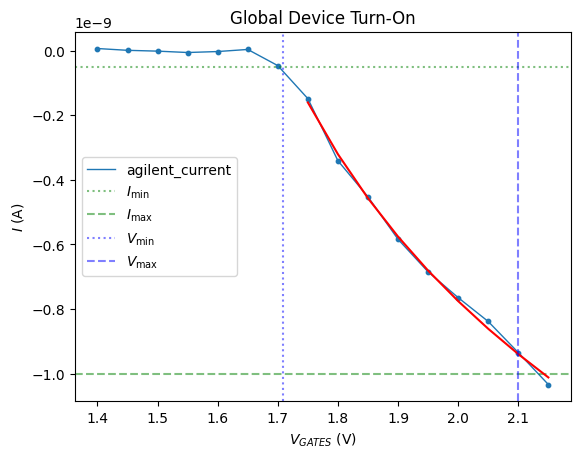

In [5]:
# Set maxV equal to None if you want to sweep 
# up to the max voltage you set in device config
# It'll stop if it hits max current or max gate voltage (it should)
QDTuner.check_turn_on(minV=1.4, maxV=2.5, dV=0.05, delay=0.001)

In [7]:
QDTuner.device_info

{'characteristics': {'sample_name': 'N44_D54',
  'charge_carrier': 'e',
  'operation_mode': 'acc',
  'ohmics': ['S'],
  'barriers': ['LB', 'RB'],
  'leads': ['STL'],
  'plungers': ['P']},
 'properties': {'abs_max_current': 1e-09,
  'abs_max_ohmic_bias': 0.001,
  'abs_max_gate_voltage': 3,
  'abs_max_gate_differential': 2.5,
  'turn_on': 1.708,
  'saturation': 2.1,
  'LB': {'pinch_off': {'value': 'N/A', 'width': 'N/A'}},
  'RB': {'pinch_off': {'value': 'N/A', 'width': 'N/A'}},
  'STR': {'pinch_off': {'value': 'N/A', 'width': 'N/A'}}}}

In [ ]:
# Set maxV equal to None if you want to use
# saturation voltage found in turn on phase.
QDTuner.check_pinch_offs(minV=1, maxV=None)

In [ ]:
QDTuner.barrier_barrier_sweep(B1='LB', B2='RB')